# 2.4 생성된 답변을 여러번 검증하는 Self-RAG

In [1]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma

embedding_function = HuggingFaceEmbeddings(model="BAAI/bge-m3")
collection_name = "chroma-income-tax-ollama_embedding"
vector_store = Chroma(
    collection_name=collection_name,
    embedding_function=embedding_function,
    persist_directory="./chroma"
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

c:\Users\a1ljm\Desktop\ANSWER_25\inflearn-langgraph-agent\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
query = "연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?"
response = retriever.invoke(query)
response

[Document(id='af7d994c-dca7-4503-90fc-5ab84e74ae38', metadata={'source': './documents/income_tax_ocr.text'}, page_content='cS 과세기간의 종합소득금액\n=== 페이지 39 시작 ===\n[일반 텍스트]\n법제처                                                            39                                                       국가법령정보센터\n소득세법\n[전문개정 2009. 12. 31.]\n \n제59조(근로소득세액공제) ①근로소득이 있는 거주자에 대해서는 그 근로소득에 대한 종합소득산출세액에서 다음의\n금액을 공제한다. <개정 2014. 1. 1., 2015. 5. 13.>\n② 제1항에도 불구하고 공제세액이 다음 각 호의 구분에 따른 금액을 초과하는 경우에 그 초과하는 금액은 없는 것\n으로 한다.<신설 2014. 1. 1., 2015. 5. 13., 2022. 12. 31.>\n1. 총급여액이 3천 300만원 이하인 경우: 74만원\n2. 총급여액이 3천 300만원 초과 7천만원 이하인 경우: 74만원 - [(총급여액 - 3천 300만원) × 8/1000]. 다만, 위 금\n액이 66만원보다 적은 경우에는 66만원으로 한다.\n3. 총급여액이 7천만원 초과 1억2천만원 이하인 경우: 66만원 - [(총급여액 - 7천만원) × 1/2]. 다만, 위 금액이 50만\n원보다 적은 경우에는 50만원으로 한다.\n4. 총급여액이 1억2천만원을 초과하는 경우: 50만원 - [(총급여액 - 1억2천만원) × 1/2]. 다만, 위 금액이 20만원보다\n적은 경우에는 20만원으로 한다.\n③ 일용근로자의 근로소득에 대해서 제134조제3항에 따른 원천징수를 하는 경우에는 해당 근로소득에 대한 산출세\n액의 100분의 55에 해당하는 금액을 그 산출세액에서 공제한다.<개정 2014. 1

In [3]:
from typing import TypedDict, List
from langchain_core.documents import Document
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

workflow = StateGraph(AgentState)

In [4]:
def retrieve(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.
    Args:
        state (AgentState): 사용자의 질문을 포함한 에이전트의 현재 state.
    Returns:
        AgentState: 검색된 문서가 추가된 state를 반환합니다.
    """
    print("retrieve")
    query = state["query"]
    docs = retriever.invoke(query)
    return {"context": docs}

In [5]:
from langchain_ollama import ChatOllama

llm_ollama = ChatOllama(model="llama3.1")

- [rlm/rag-prompt](https://smith.langchain.com/hub/rlm/rag-prompt)
- HUMAN
    - You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    - Question: {question} 
    - Context: {context} 
- Answer:

In [6]:
from langchain_classic import hub

generate_prompt = hub.pull("rlm/rag-prompt")
# generate_llm = ChatOllama(model="llama3.1", max_completion_tokens=100)

def generate(state: AgentState) -> AgentState:
    """
    주어진 state를 기반으로 RAG 체인을 사용하여 응답을 생성합니다.
    Args:
        state (AgentState): 사용자의 질문과 문맥을 포함한 에이전트의 현재 state.
    Returns:
        AgentState: 생성된 응답을 포함하는 state를 반환합니다.
    """
    print("generate")
    query = state["query"]
    context = state["context"]
    generate_chain = generate_prompt | llm_ollama  # generate_llm (X)
    response = generate_chain.invoke({"question": query, "context": context})
    return {"answer": response}

- [langchain-ai/rag-document-relevance](https://smith.langchain.com/hub/langchain-ai/rag-document-relevance)
- HUMAN
    - FACTS: {{documents}}
    - QUESTION: {{question}}
- Score:
    - A score of 1 means that the FACT contain ANY keywords or semantic meaning related to the QUESTION and are therefore relevant. This is the highest (best) score. 
    - A score of 0 means that the FACTS are completely unrelated to the QUESTION. This is the lowest possible score you can give.

In [ ]:
from typing import Literal

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def is_doc_relevant(state: AgentState) -> Literal["relevant", "irrelevant"]:
    """
    """
    print("is_doc_relevant")
    query = state["query"]
    context = state["context"]
    doc_relevance_chain = doc_relevance_prompt | llm_ollama
    response = doc_relevance_chain.invoke({"question": query, "documents": context})
    if response["Score"] == 1:
        print("---> relevant")
        return "relevant"
    print("---> irrelevant")
    return "irrelevant"

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ["사람과 관련된 표현은 '거주자'로 바꿉니다."]
template = f"""
    아래 사전을 참고해서 사용자의 질문을 변경합니다.
    사전: {dictionary}
    질문: {{query}}
"""
rewrite_prompt = PromptTemplate.from_template(template=template)

def rewrite(state: AgentState) -> AgentState:
    """
    """
    print("rewrite")
    query = state["query"]
    rewrite_chain = rewrite_prompt | llm_ollama | StrOutputParser()
    response = rewrite_chain.invoke({"query": query})
    return {"query": response}

- [langchain-ai/rag-answer-hallucination](https://smith.langchain.com/hub/langchain-ai/rag-answer-hallucination)
- HUMAN
    - FACTS: {{documents}} 
    - STUDENT ANSWER: {{student_answer}}
- Score:
    - A score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score. 
    - A score of 0 means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

In [ ]:
hallucination_prompt = hub.pull("langchain-ai/rag-answer-hallucination")
hallucination_llm = ChatOllama(model="llama3.1", temperature=0)

def is_hallucinated(state: AgentState) -> Literal["hallucinated", "non-hallucinated"]:
    """
    """
    print("is_hallucinated")
    context = state["context"]
    answer = state["answer"]
    hallucination_chain = hallucination_prompt | hallucination_llm
    response = hallucination_chain.invoke({"documents": context, "student_answer": answer})
    if response["Score"] == 1:
        print("---> non-hallucinated")
        return "non-hallucinated"
    print("---> hallucinated")
    return "hallucinated"

In [10]:
# query = "연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?"
# context = retriever.invoke(query)
# answer = generate({"query": query, "context": context})
# is_hallucinated({"context": context, "answer": answer})

- [langchain-ai/rag-answer-helpfulness](https://smith.langchain.com/hub/langchain-ai/rag-answer-helpfulness)
- HUMAN
    - STUDENT ANSWER: {{student_answer}}
    - QUESTION: {{question}}
- Score:
    - A score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score. 
    - A score of 0 means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

In [ ]:
helpful_prompt = hub.pull("langchain-ai/rag-answer-helpfulness")

def is_helpful(state: AgentState) -> Literal["helpful", "unhelpful"]:
    """
    """
    print("is_helpful")
    query = state["query"]
    answer = state["answer"]
    helpful_chain = helpful_prompt | llm_ollama
    response = helpful_chain.invoke({"question": query, "student_answer": answer})
    if response["Score"] == 1:
        print("---> helpful")
        return "helpful"
    print("---> unhelpful")
    return "unhelpful"

def check_helpfulness(state: AgentState) -> AgentState:
    """
    사용자의 질문에 기반하여 생성된 답변의 유용성을 평가합니다.
    Args:
        state (AgentState): 사용자의 질문과 생성된 답변을 포함한 에이전트의 현재 state.
    Returns:
        str: 답변이 유용하다고 판단되면 'helpful', 그렇지 않으면 'unhelpful'을 반환합니다.
    """
    print("check_helpfulness")
    return state

In [12]:
from langgraph.graph import START, END

workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_node("rewrite", rewrite)
workflow.add_node("check_helpfulness", check_helpfulness)

workflow.add_edge(START, "retrieve")
workflow.add_conditional_edges("retrieve", is_doc_relevant, {
    "relevant": "generate",
    "irrelevant": END,
})
workflow.add_conditional_edges("generate", is_hallucinated, {
    "hallucinated": "generate",
    "non-hallucinated": "check_helpfulness",
})
workflow.add_conditional_edges("check_helpfulness", is_helpful, {
    "helpful": END,
    "unhelpful": "rewrite"
})

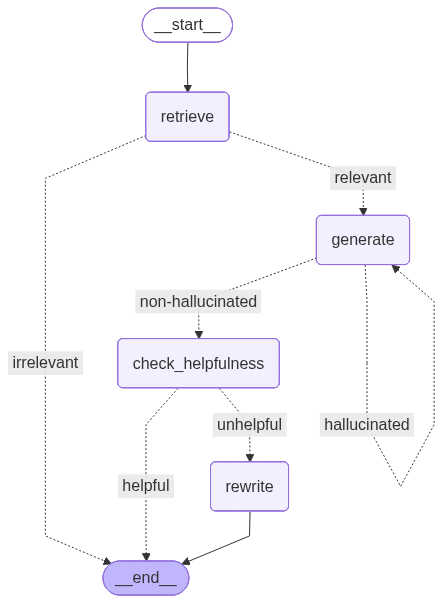

In [14]:
from IPython.display import display, Image

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
query = "연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?"

response = graph.invoke({"query": query})
response

retrieve
is_doc_relevant
generate
is_hallucinated
check_helpfulness
is_helpful


{'query': '연봉 5천만원인 거주자가 납부해야 하는 소득세는 얼마인가요?',
 'context': [Document(id='af7d994c-dca7-4503-90fc-5ab84e74ae38', metadata={'source': './documents/income_tax_ocr.text'}, page_content='cS 과세기간의 종합소득금액\n=== 페이지 39 시작 ===\n[일반 텍스트]\n법제처                                                            39                                                       국가법령정보센터\n소득세법\n[전문개정 2009. 12. 31.]\n \n제59조(근로소득세액공제) ①근로소득이 있는 거주자에 대해서는 그 근로소득에 대한 종합소득산출세액에서 다음의\n금액을 공제한다. <개정 2014. 1. 1., 2015. 5. 13.>\n② 제1항에도 불구하고 공제세액이 다음 각 호의 구분에 따른 금액을 초과하는 경우에 그 초과하는 금액은 없는 것\n으로 한다.<신설 2014. 1. 1., 2015. 5. 13., 2022. 12. 31.>\n1. 총급여액이 3천 300만원 이하인 경우: 74만원\n2. 총급여액이 3천 300만원 초과 7천만원 이하인 경우: 74만원 - [(총급여액 - 3천 300만원) × 8/1000]. 다만, 위 금\n액이 66만원보다 적은 경우에는 66만원으로 한다.\n3. 총급여액이 7천만원 초과 1억2천만원 이하인 경우: 66만원 - [(총급여액 - 7천만원) × 1/2]. 다만, 위 금액이 50만\n원보다 적은 경우에는 50만원으로 한다.\n4. 총급여액이 1억2천만원을 초과하는 경우: 50만원 - [(총급여액 - 1억2천만원) × 1/2]. 다만, 위 금액이 20만원보다\n적은 경우에는 20만원으로 한다.\n③ 일용근로자의 근로소득에 대해서 제134조제3항에 따른 원천징수를 하는 경우에는 해당 근로

In [16]:
print(response["answer"].content)

연봉 5천만원인 거주자가 납부해야 하는 소득세는 연 1,724만원입니다. 이는 총급여액이 7천만원 초과 12천만원 이하인 경우의 공제 금액에 해당합니다. (66만원 - [(총급여액 - 7천만원) × 1/2])
